In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from matplotlib.pyplot import figure
import plotly.express as px
from mplcursors import cursor  # separate package must be installed
from os import listdir

import utils


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [31]:
# https://www.kaggle.com/code/sahilgarg108/hyperparameter-tuning-92-f1-auc-roc
# https://www.fao.org/faostat/en/#data/QCL
# FAOSTAT_data_en_4-21-2024.csv
# https://www.kirenz.com/blog/posts/2022-06-17-sentiment-analysis-with-tensorflow-and-keras/

# FAO
# https://www.fao.org/faostat/en/#data/RFB -- > Fertilizer use
# https://www.fao.org/faostat/en/#data/QCL --> Crops and livestock products

# World Bank Indicators 
# https://data.worldbank.org/indicator
# https://databank.worldbank.org/reports.aspx?source=2&series=NV.AGR.TOTL.ZS&country=

# https://www.ers.usda.gov/webdocs/outlooks/40408/30645_wrs0404e_002.pdf


27

22

5

{'Hungary', 'Poland', 'Romania', 'Slovakia', 'Slovenia'}

In [ ]:
# Time series analysis
# https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python


In [32]:
# Returns a cleaned up dataframe with columns dropped and column names converted into 'variable name' like format
def do_basic_cleanup(df, drop_cols):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    return df

In [35]:
df = pd.DataFrame()

for file in listdir('data'):
  df_part = pd.read_csv("data/" + file, on_bad_lines='warn')
  df_part = do_basic_cleanup(df_part, ['domain_code', 'area_code_m49', 'element_code', 'item_code_cpc', 'year_code', 'note', 'flag'])
  print(file, df_part.shape)
  df = pd.concat([df, df_part], ignore_index=True)

print('Number of unique countries:', len(df.area.unique()))

FAOSTAT_data_en_4-28-2024_Port_Swe.csv (41402, 8)
FAOSTAT_data_en_5-4-2024_smaller_countries.csv (63759, 8)
FAOSTAT_data_en_4-28-2024_Ger_Neth.csv (55646, 8)
FAOSTAT_data_en_4-28-2024_Aust_Fin.csv (46988, 8)
FAOSTAT_data_en_5-4-2024_eastern_eur.csv (52769, 8)
FAOSTAT_data_en_4-28-2024_IRL.csv (6452, 8)
Number of unique countries: 27


In [36]:
df.value = df.value.astype('int64')
df.shape
df.head()

(267016, 8)

,domain,area,element,item,year,unit,value,flag_description
0,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1961,ha,37000,Estimated value
1,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1961,100 g/ha,4324,Estimated value
2,Crops and livestock products,Portugal,Production,"Almonds, in shell",1961,t,16000,Official figure
3,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1962,ha,38000,Estimated value
4,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1962,100 g/ha,4737,Estimated value


In [7]:
df.unit.value_counts()

unit
t           61419
ha          49394
100 g/ha    39675
Name: count, dtype: int64

In [37]:
def calc_means(df):
  df = df[['item', 'element', 'area', 'value']]
  return df.groupby(by=['item', 'element', 'area'], as_index=False).mean()

means_df = calc_means(df).rename(columns={'value': 'all_time_mean'})
means_df.all_time_mean = means_df.all_time_mean.apply(lambda x: round(x, 2))

means_df = means_df.reset_index()
means_df.shape
means_df.head()

(6697, 5)

,index,item,element,area,all_time_mean
0,0,"Almonds, in shell",Area harvested,Belgium,0.00
1,1,"Almonds, in shell",Area harvested,Bulgaria,894.61
2,2,"Almonds, in shell",Area harvested,Croatia,574.45
3,3,"Almonds, in shell",Area harvested,Cyprus,4970.48
4,4,"Almonds, in shell",Area harvested,Estonia,0.00


In [38]:
df = df.merge(means_df, on=['item', 'element', 'area'])
df.shape

(267016, 10)

In [56]:
percentiles = pd.DataFrame()

PERCENTILE_LABELS = ["0-25%", "25-50%", "50-75%", "75-100%"]

for el in df.element.unique().tolist():
  for area in df.area.unique().tolist():
    q = df[(df.element == el) & (df.area == area)][['item', 'element', 'area', 'all_time_mean']].drop_duplicates()
    q['percentile'] = pd.qcut(df.value, np.linspace(0,1,5), labels=PERCENTILE_LABELS)
    q = q.drop(columns=['all_time_mean'])
    percentiles = pd.concat([percentiles, q], ignore_index=True)

percentiles = percentiles.reset_index(drop=True)
percentiles.shape
percentiles.head()


(6697, 4)

,item,element,area,percentile
0,"Almonds, in shell",Area harvested,Portugal,50-75%
1,Apples,Area harvested,Portugal,50-75%
2,Apricots,Area harvested,Portugal,25-50%
3,Artichokes,Area harvested,Portugal,0-25%
4,Asparagus,Area harvested,Portugal,0-25%


In [40]:
df = df.merge(percentiles, on=['item', 'element', 'area'])
df.shape

(267016, 11)

In [41]:
df.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
267011,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,6630,529232.56,75-100%
267012,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,6630,529232.56,75-100%
267013,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,6630,529232.56,75-100%
267014,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,6630,529232.56,75-100%
267015,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,6630,529232.56,75-100%


In [42]:
df.describe()

,year,value,index,all_time_mean
count,267016.000000,2.670160e+05,267016.000000,2.670160e+05
mean,1994.723885,2.075236e+05,3381.658496,2.075236e+05
std,17.666619,1.226368e+06,1940.839557,1.151618e+06
min,1961.000000,0.000000e+00,0.000000,0.000000e+00
25%,1980.000000,5.520000e+02,1673.000000,1.370340e+03
50%,1997.000000,1.191100e+04,3347.000000,1.482889e+04
75%,2010.000000,7.390325e+04,5088.000000,8.171274e+04
max,2022.000000,5.192821e+07,6696.000000,2.807130e+07


In [46]:
d = df[(df.value > 0.0) & (df.unit == 't') & (df['percentile'] == '75-100%')]
d.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
2899,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1961,t,82000,Official figure,1423,35103.69,75-100%
2900,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1962,t,96000,Official figure,1423,35103.69,75-100%
2901,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1963,t,64000,Official figure,1423,35103.69,75-100%
2902,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1964,t,90000,Official figure,1423,35103.69,75-100%
2903,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1965,t,47000,Official figure,1423,35103.69,75-100%


In [49]:
top_irish_crops = data=df[(df.value > 0.0) & (df.area == 'Ireland') & (df.unit == 't') & (df['percentile'] == '75-100%')]

<Figure size 960x480 with 0 Axes>

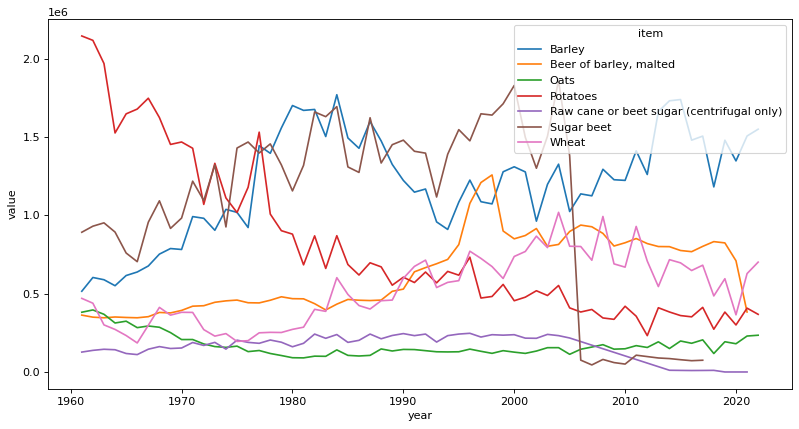

In [50]:
figure(figsize=(12, 6), dpi=80)
_ = sns.lineplot(data=top_irish_crops, x='year', y='value', hue='item')
_ = plt.show()

From: https://plotly.com/python/line-charts/

In [67]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.tools as tls


In [101]:
app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id="area",
                options=df.area.unique(),
                value="Ireland",
            ),
            dcc.RadioItems(
                PERCENTILE_LABELS,
                PERCENTILE_LABELS[-1],
                id="percentile",
                inline=True,
            )
        ], style={'width': '40%', 'display': 'inline-block'}),
    ]),
    dcc.Graph(id="line-graph"),
    dcc.Graph(id="bar-graph"),
])


@app.callback([
    Output("line-graph", "figure"), 
    Output("bar-graph", "figure")], 
    Input("percentile", "value"),
    Input("area", "value"))
def update_line_chart(percentile, area):
    data=df[(df.value > 0.0) & (df.unit == 't') & (df.area == area) & (df.percentile == percentile)]
    return (px.line(data, x="year", y="value", color='item', title=f"{percentile} Crops Production in {area}"), 
            px.bar(data, x="year", y="value", color="item", title=f"{percentile} Crops Production in {area}"))


app.run_server(debug=True)

In [122]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="item",
            options=top_irish_crops.item.unique(),
            value="Barley",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=df.element.unique(),
            value="Production",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
            dcc.Checklist(
                id="areas",
                options=df.area.unique(),
                value=["Belgium", "Ireland"]
            ),
        ], style={'width': '15%', 'float': 'right', 'display': 'inline-block', "backgroundColor": "#fafbfc"}),
    html.Div([
        html.Div([
           dcc.Graph(id="graph"),
        ], style={'width': '84%', 'float': 'left'}),
    ])
])


@app_comp.callback(
    Output("graph", "figure"), 
    Input("item", "value"),
    Input("metric", "value"),
    Input("areas", "value"))
def update_line_chart(item, metric, areas):
    data=df[(df.value > 0.0) & 
            (df.item == item) & 
            (df.element == metric) & 
            (df.area.isin(areas))]
    return px.line(data, x="year", y="value", color='area')


app_comp.run_server(debug=True, port=8051)

In [142]:
df_unstacked = df.pivot(index=['year', 'area', 'item'], columns='element', values='value').dropna().reset_index(['year', 'area', 'item'])
df_unstacked.head()

ELEMENTS = ['Area harvested', 'Production', 'Yield']

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Asparagus,35.0,150.0,42857.0
1,1961,Austria,Barley,187648.0,511571.0,27262.0
2,1961,Austria,"Beans, dry",682.0,1160.0,17009.0
3,1961,Austria,"Broad beans and horse beans, dry",659.0,1635.0,24810.0
4,1961,Austria,Buckwheat,224.0,256.0,11429.0


In [118]:
df_unstacked = df_unstacked[(df_unstacked.year >= 1990) & (df_unstacked.Production > 0)]

<Axes: xlabel='element', ylabel='element'>

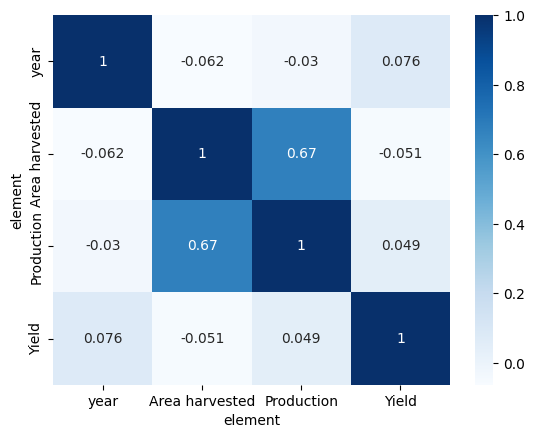

In [180]:
corr = df_unstacked[['year', 'Area harvested', 'Production', 'Yield']].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

# Statistics

In [127]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats import weightstats

#Importing the libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

In [51]:
# https://www.kaggle.com/code/brekhnaa/analysis-of-variance-anova

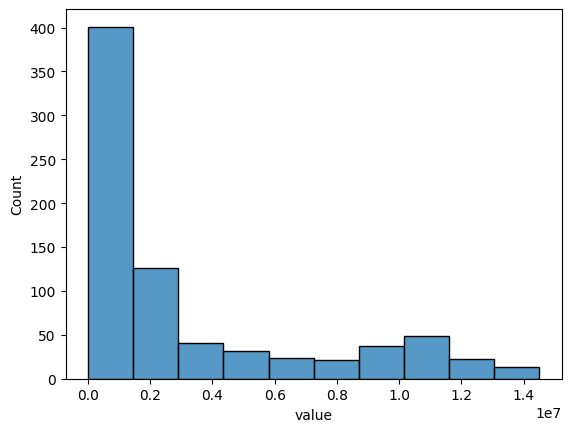

In [21]:
barley_data = df[(df.element == 'Production') & (df.item == 'Barley')]
_ = sns.histplot(data=barley_data, x='value', bins=10)


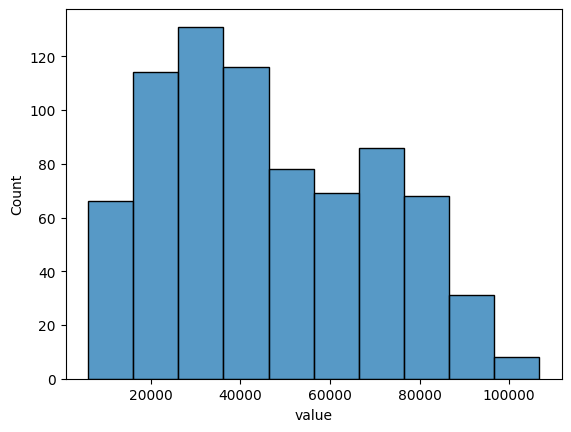

In [41]:
wheat_yield = df[(df.value > 0.0) & (df.item == 'Wheat') & (df.element == 'Yield')]
_ = sns.histplot(data=wheat_yield, x='value', bins=10)


In [158]:
def filter_df(df, item, metric, area, year):
    return df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & (df.area == area) & (df.year >= year)]

Based on the graph above epxlore similarities between barley production in Ireland vs Sweden

In [32]:
# Barley Sweden vs Ireland

X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 1961)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 1961)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-8.274887082484733, pvalue=2.108363734344893e-13, df=119.35353288843136)

As pvalue is lower than alpha, we reject the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are differences between Itish and Swedish barley production as observed from year 1961 until 2022.

In [33]:
# Barley Sweden vs Ireland post 2006
X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 2006)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-1.1251166718413368, pvalue=0.2692174781299017, df=30.849374886060687)

As pvalue is higher than alpha, we **accept** the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are NO differences between Itish and Swedish barley production as observed from year 2006 until 2022.

Assumption is that one of the contributing factors could be introduction of CAP.

In [172]:

# Oats Czechia vs Ireland post 2006
X1 = filter_df(df, 'Oats', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Oats', 'Production', 'Czechia', 2006) 

t_test_oats = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_oats

TtestResult(statistic=2.1492199461011676, pvalue=0.04159312462200444, df=24.746714809060233)

### Check whether Barley production in Ireland is normally distributed.
Null Hypothesis H0: Barley production in Ireland follows normal distribution.

In [42]:
k2, p = stats.normaltest(filter_df(df, 'Barley', 'Production', 'Ireland', 1961).value)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.199551
The null hypothesis cannot be rejected


In [125]:
k2, p = stats.normaltest(df[(df.value > 0.0) & (df.area == 'Ireland') & (df.item == 'Wheat') & (df.element == 'Yield')].value)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.01955e-05
The null hypothesis can be rejected


In [128]:
df_unstacked.head()

element,year,area,item,Area harvested,Production,Yield
24250,1990,Austria,Apricots,1000.0,10695.0,106974.0
24251,1990,Austria,Asparagus,164.0,640.0,39024.0
24252,1990,Austria,Barley,292424.0,1520554.0,51998.0
24253,1990,Austria,"Broad beans and horse beans, dry",9800.0,30000.0,30612.0
24254,1990,Austria,Cabbages,1079.0,54087.0,501270.0


/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_27473/4034093029.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



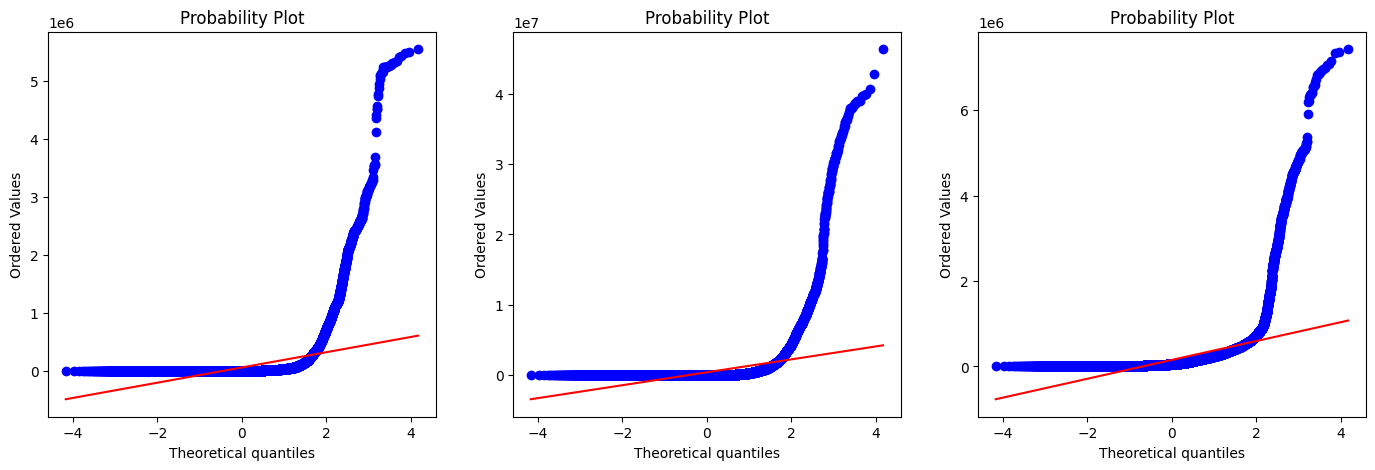

In [131]:
#Check normality of the data for Production & Yield & Area Harvested
# Probability plot - QQ plot
# https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, element in enumerate(ELEMENTS):
   _ = stats.probplot(df_unstacked[element], plot=axes[i]);
  #plt.figure();
f.show()

In [140]:
# Shapiro Wilk Test - Normality test
# This test is hypothesis test that will hel design if the data is normal or not
# H0 - data normally distributed
# H1 - data NOT normally distributed

SHAPIRO_MAX_SAMPLE = 5000

for element in ELEMENTS:
   res = stats.shapiro(df_unstacked[element])
   print(f"{element}: {res}")
    
   res_sampled = stats.shapiro(df_unstacked[element].sample(n=SHAPIRO_MAX_SAMPLE, random_state=1))
   print(f"{element}, sampled: {res_sampled}")

   print("Pvalue difference of ", res.pvalue - res_sampled.pvalue, "\n")


/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_27473/1256165243.py:9: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 46153.



Area harvested: ShapiroResult(statistic=0.20994859776321062, pvalue=9.190668595446142e-154)
Area harvested, sampled: ShapiroResult(statistic=0.20422198405201453, pvalue=1.6123396778196508e-90)
Pvalue difference of  -1.6123396778196508e-90 

Production: ShapiroResult(statistic=0.1975117871066565, pvalue=2.9272425031190985e-154)
Production, sampled: ShapiroResult(statistic=0.20071177350533997, pvalue=1.2769184330894704e-90)
Pvalue difference of  -1.2769184330894704e-90 

Yield: ShapiroResult(statistic=0.3070087961593506, pvalue=1.262992525008552e-149)
Yield, sampled: ShapiroResult(statistic=0.2797804551015073, pvalue=3.075756157062451e-88)
Pvalue difference of  -3.075756157062451e-88 



**Interpretation**: Reject hypothesis, becasue P is smaller than Alpha

In [141]:
top_irish_crops.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
260914,Crops and livestock products,Ireland,Production,Barley,1961,t,515400,Official figure,517,1201982.74,75-100%
260915,Crops and livestock products,Ireland,Production,Barley,1962,t,603200,Official figure,517,1201982.74,75-100%
260916,Crops and livestock products,Ireland,Production,Barley,1963,t,588900,Official figure,517,1201982.74,75-100%
260917,Crops and livestock products,Ireland,Production,Barley,1964,t,550699,Official figure,517,1201982.74,75-100%
260918,Crops and livestock products,Ireland,Production,Barley,1965,t,615730,Official figure,517,1201982.74,75-100%


In [153]:
# Now we can analyse normality by Product and Category (yield / production)
alpha = 0.05

results = []
for item in top_irish_crops.item.unique():
    for area in df_unstacked.area.unique():
        crop_df = df_unstacked[(df_unstacked.item == item) & (df_unstacked.area == area)]
        for element in ELEMENTS:
            crop_el_df = crop_df[element]
            if crop_el_df.shape[0] < 3:
                continue
            res_sampled = stats.shapiro(crop_el_df)
            # if res_sampled.pvalue < alpha, then null hypothesis: x comes from a normal distribution
            results.append([item, area, element, crop_df.shape[0], res_sampled.pvalue, res_sampled.pvalue < alpha])

In [152]:
shapiro_per_category = pd.DataFrame(data=results, columns=['item', 'area', 'element', 'sample_size', 'pval', 'is_normal'])
shapiro_per_category.head(100)
shapiro_per_category.shape

,item,area,element,sample_size,pval,is_normal
0,Barley,Austria,Area harvested,62,2.871147e-02,True
1,Barley,Austria,Production,62,3.836077e-02,True
2,Barley,Austria,Yield,62,4.768819e-01,False
3,Barley,Bulgaria,Area harvested,62,4.627617e-01,False
4,Barley,Bulgaria,Production,62,8.929668e-03,True
...,...,...,...,...,...,...
95,Oats,Finland,Yield,62,5.628891e-02,False
96,Oats,France,Area harvested,62,1.377821e-07,True
97,Oats,France,Production,62,1.047801e-06,True
98,Oats,France,Yield,62,7.851284e-03,True


(393, 6)

In [155]:
shapiro_per_category[(shapiro_per_category.item == 'Barley') & shapiro_per_category.is_normal == True].head(30)

,item,area,element,sample_size,pval,is_normal
0,Barley,Austria,Area harvested,62,2.871147e-02,True
1,Barley,Austria,Production,62,3.836077e-02,True
4,Barley,Bulgaria,Production,62,8.929668e-03,True
6,Barley,Cyprus,Area harvested,62,4.509056e-02,True
9,Barley,Denmark,Area harvested,62,1.218209e-05,True
10,Barley,Denmark,Production,62,1.438472e-03,True
12,Barley,Finland,Area harvested,62,1.606509e-02,True
13,Barley,Finland,Production,62,1.041218e-03,True
14,Barley,Finland,Yield,62,3.552999e-02,True
15,Barley,France,Area harvested,62,6.485802e-05,True


In [156]:
df.area.unique()

array(['Portugal', 'Spain', 'Sweden', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Estonia', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Germany', 'Greece', 'Italy', 'Netherlands (Kingdom of the)',
       'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Hungary',
       'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Ireland'],
      dtype=object)

##### Levene Test
Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

The Levene test is less sensitive than the Bartlett test to departures from normality. If you have strong evidence that your data do in fact come from a normal, or nearly normal, distribution, then Bartlett's test has better performance.
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm#:~:text=Levene's%20test%20is%20an%20alternative,Bartlett's%20test%20has%20better%20performance.

In [167]:
# Levene test on Barley Yield
dfs = [filter_df(df, 'Barley', 'Yield', 'Ireland', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Germany', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'France', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Belgium', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Denmark', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Netherlands (Kingdom of the)', 2006).value]

stats.levene(*dfs, center = 'mean')
stats.bartlett(*dfs)

LeveneResult(statistic=1.3615854886536825, pvalue=0.24563360972459522)

BartlettResult(statistic=5.5483829539909, pvalue=0.352669678198435)

**Interpretation**: accept that all inout samples are from populations with equal variances.

In [168]:
stats.levene(filter_df(df, 'Oats', 'Production', 'Ireland', 2006).value, 
            filter_df(df, 'Oats', 'Production', 'Czechia', 2006).value, 
            center = 'mean')

LeveneResult(statistic=5.874194676640041, pvalue=0.02119514502306541)

In [176]:
# ANOVA ######
# H0: Average cgarges the same for all locations
# H1: There is at least one average difference than others
# ols('X~categorical variable')

data = df_unstacked[df_unstacked.area.isin(['Ireland', 'Germany', 'France', 'Belgium', 'Denmark', 'Netherlands (Kingdom of the)'])]

model = ols('Yield~area', data=data).fit()
aov = sm.stats.anova_lm(model, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
area,5.0,2.666526e+14,5.333053e+13,140.457877,5.941663e-146
Residual,14373.0,5.457292e+15,3.796906e+11,NaN,NaN


**Conclusion** At 5% significance level there is NOT enough evidence to suggest that the average charges per region are the same.
Reject the Null hypothesis

In [73]:
model = ols('BodyFat~Day', data=df_body).fit()
aov = sm.stats.anova_lm(model, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Day,5.0,103.893554,20.778711,0.294594,0.915649
Residual,245.0,17280.678637,70.533382,NaN,NaN


We accept the null hypothesis

## Time Series

In [52]:
# https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide

## Clustering

## Sentiment Analysis

In [ ]:
https://www.kaggle.com/code/michawilkosz/twitter-sentiment-analysis-using-tensorflow